# *Keras* API data to model a CNN.

This `HTML` tag, used in a `Jupyter Notebook` cell, hides all error messages (standard error output) in the notebook by setting their display style to 'none'. It targets div elements with the class `output_stderr`, which are used to show error outputs. Source: https://stackoverflow.com/questions/58275372/how-do-i-make-a-div-set-to-style-display-none-by-default

In [1]:
%%html
<style>
    div.output_stderr { display: none; }
</style>

In [2]:
# Importing needed packages.

import time           # Built-in, no version.
import keras          # Version 2.14.0.
import numpy as np    # Version 1.26.4.
import pandas as pd   # Version 2.2.1.
from datetime import datetime             # Built-in, no version.
from keras.datasets import imdb           # Version 2.14.0.
import matplotlib.pyplot as plt           # Version 3.5.1.
from keras.utils import plot_model        # Version 2.14.0.
from keras.models import Sequential       # Version 2.14.0.
from keras import layers, regularizers    # Version 2.14.0.
from keras.preprocessing import sequence  # Version 2.14.0.

2024-04-05 11:25:48.582251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 11:25:48.904484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 11:25:48.904960: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 11:25:48.906417: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-05 11:25:49.069762: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-05 11:25:49.072475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# 1. Importing Imdb dataset.

In [3]:
# Specifying number of features and length

max_features = 2000 # Limiting the words the model will consider the top 2000 most frequently ocurring words.
max_len = 500 # Each review will be truncated to 500 words if it's longer than that, or padded with zeros if shorter.

In [4]:
# Loading Imdb dataset and splitting it in training and test sets.

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Sequence padding, since NN require inputs to te the same size, sequences need to be padded to have the same lenght.

x_train = sequence.pad_sequences(x_train, maxlen=max_len) 
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

* `x_train` and `x_test` are lists of reviews, where each review is a sequence of integers corresponding to the words in the review:

In [5]:
x_train

array([[  0,   0,   0, ...,  19, 178,  32],
       [  0,   0,   0, ...,  16, 145,  95],
       [  0,   0,   0, ...,   7, 129, 113],
       ...,
       [  0,   0,   0, ...,   4,   2,   2],
       [  0,   0,   0, ...,  12,   9,  23],
       [  0,   0,   0, ..., 204, 131,   9]], dtype=int32)

* `y_train` and `y_test` are lists of labels, where each label is either 0 or 1, indicating the sentiment of the respective review (0 for negative and 1 for positive):

In [6]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

## 1.1. Why we don't see text, if Imdb is a dataset based on reviews??

### The reason is that CNNs operate on numbers, not words that is why the text has been preprocessed as it follows:

1. **Tokenization:** Each review is split into words, and each word is then mapped to a unique integer, creating a dictionary of word-index pairs where each word is associated with a unique number.

2. **Index Representation:** The reviews are converted to sequences of integers. For example, a word that is the 19th entry in the word index will be represented by the number 19. This representation is what you see in x_train and x_test.

3. **Truncation and Padding:** To ensure all sequences are of the same length, they are truncated or padded with zeros. This is necessary because most machine learning models require input data of consistent dimensions.

# 2. CNN implementation.
## 2.1 Phase 1 initial model.

In [7]:
#  Building the model CNN structure
model = Sequential() # linear stacks of layers, below layers are added, each layer has one input/output tensor.
model.add(layers.Embedding(max_features, 128,input_length=max_len,name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed (Embedding)           (None, 500, 128)          256000    
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 3

### Breaking down the model:

1. **Sequential Model:** Creates a linear model where layers are added in sequence.
2. **Embedding Layer:** Transforms word indices into dense vectors of fixed size and creates an input matrix.
3. **First Convolutional 1D Layer:** Applies 32 filters of size 7 to extract features from the embedded input.
4. **Max Pooling 1D Layer:** Reduces the dimensionality by taking the maximum value over windows of size 5.
5. **Second Convolutional 1D Layer:** Further extracts higher-level features using another set of 32 filters of size 7.
6. **Global Max Pooling 1D Layer:** Condenses feature maps from the entire sequence into a single vector to capture the most significant features.
7. **Dense Layer:** Outputs the final prediction as a single continuous value from the condensed features.

In [8]:
# Compiling the model
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

1. `rmsprop:` Utilizing `rmsprop` optimization algorithm to adjust weights to minimize the loss function.
2. `binary_crossentropy:` Usesing binary crossentropy to measure how far the predictions are from the actual binary labels.
3. `accuracy:` Tracking accuracy of predictions, the percentage of correct predictions over the training and validation data.

In [9]:
# Train the model
start_time = time.time()
history = model.fit(x_train, y_train,epochs=20,batch_size=128,validation_split=0.2)
end_time = time.time()

Epoch 1/20


2024-04-05 11:25:55.715012: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 40000000 exceeds 10% of free system memory.
2024-04-05 11:25:56.349205: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32768000 exceeds 10% of free system memory.
2024-04-05 11:25:56.450488: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30098432 exceeds 10% of free system memory.
2024-04-05 11:25:56.451162: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32768000 exceeds 10% of free system memory.


  1/157 [..............................] - ETA: 2:10 - loss: 1.2261 - accuracy: 0.5000

2024-04-05 11:25:56.677605: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32768000 exceeds 10% of free system memory.


157/157 [==============================] - 38s 239ms/step - loss: 0.6025 - accuracy: 0.6760 - val_loss: 0.4174 - val_accuracy: 0.8376
Epoch 2/20
157/157 [==============================] - 33s 209ms/step - loss: 0.4367 - accuracy: 0.8461 - val_loss: 0.3889 - val_accuracy: 0.8608
Epoch 3/20
157/157 [==============================] - 33s 210ms/step - loss: 0.3733 - accuracy: 0.8782 - val_loss: 0.5071 - val_accuracy: 0.8660
Epoch 4/20
157/157 [==============================] - 32s 205ms/step - loss: 0.3162 - accuracy: 0.9004 - val_loss: 0.5486 - val_accuracy: 0.8582
Epoch 5/20
157/157 [==============================] - 33s 211ms/step - loss: 0.2774 - accuracy: 0.9184 - val_loss: 0.5740 - val_accuracy: 0.8682
Epoch 6/20
157/157 [==============================] - 36s 228ms/step - loss: 0.2394 - accuracy: 0.9392 - val_loss: 0.6014 - val_accuracy: 0.8750
Epoch 7/20
157/157 [==============================] - 32s 205ms/step - loss: 0.1990 - accuracy: 0.9549 - val_loss: 0.9359 - val_accuracy: 0.8

* `epochs=20`: Specifying epochs number to train the model. An epoch is one complete pass through the entire training dataset. In this case, the model will go through the X and y data 20 times during the training process.
* `batch_size=128`: Defining the number of samples that will be propagated through the network before the model's internal parameters (weights) are updated. In this case, it processes in mini-batches of 128 samples at a time.
* `verbose=2`: This controls the verbosity of the training process output. verbose=2 will just mention the number of the epoch and the loss and accuracy for that epoch at each epoch end.

In [10]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Model running time: {minutes} minutes {seconds} seconds")

Model running time: 11 minutes 21 seconds


Plotting Training and Validation scores for Accuracy and Loss.

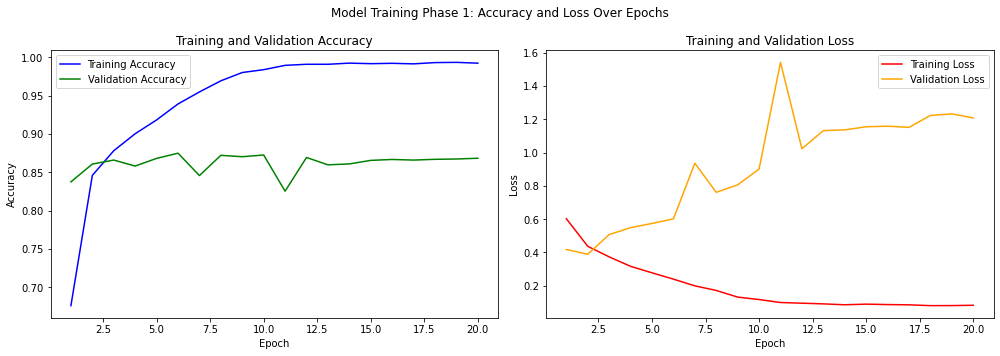

In [11]:
# Converting history into a DataFrame
history_df = pd.DataFrame(history.history)

# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))

# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.plot(epochs_range, history_df['val_accuracy'].values, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.plot(epochs_range, history_df['val_loss'].values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Model Training Phase 1: Accuracy and Loss Over Epochs")
plt.tight_layout()
plt.show()

## Model Phase 1 evaluation:
The model's training accuracy improves while the loss decreases, indicating it learns effectively from the training data. However, the validation loss initially decreases but then increases, and the validation accuracy plateaus, which suggests overfitting, this means the model doesn't generalize well to new, unseen data.

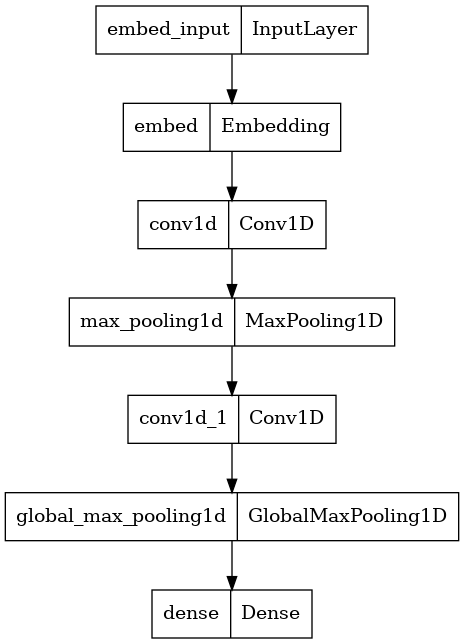

In [12]:
# CNN Architecture for Text Classification:

plot_model(model, to_file='model.png')

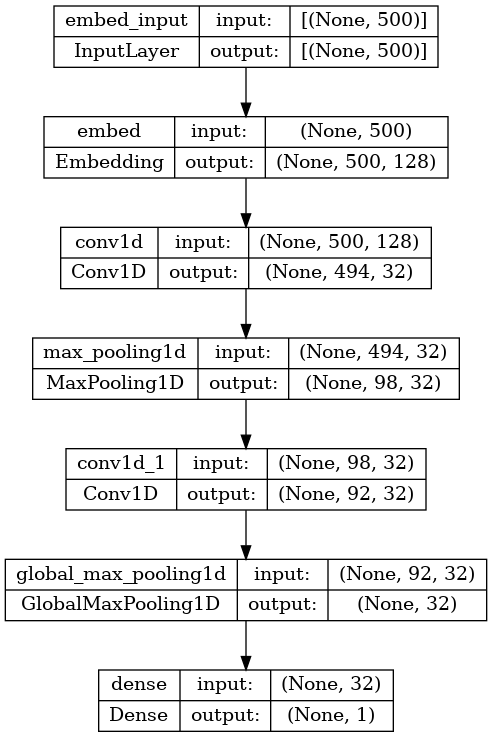

In [13]:
# Detailed CNN Architecture with Layer Outputs for Text Classification:

plot_model(model, show_shapes=True, to_file='model.png')

## 2.2 Phase 2 mitigating overfitting.

In this phase the model aims to reduce overfitting by including dropout layers (Khan, Hayat and Porikli, 2019), using L2 regularization, simplifying the network with fewer and smaller convolutional filters, and decreasing the embedding dimensionality.

In [14]:

# Load and preprocess data:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# Define the model:
model = keras.models.Sequential()

# Add an Embedding layer with dropout:
model.add(layers.Embedding(max_features, 64, input_length=max_len))
model.add(layers.Dropout(0.4))

# Add a Conv1D layer with L2 regularization:
model.add(layers.Conv1D(16, 3, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.001)))

# Add a MaxPooling1D layer:
model.add(layers.MaxPooling1D(5))

# Add a GlobalMaxPooling1D layer to reduce the number of features:
model.add(layers.GlobalMaxPooling1D())

# Add a Dense layer with L2 regularization and dropout:
model.add(layers.Dense(16, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.4))

# Add the output layer with sigmoid activation for binary classification:
model.add(layers.Dense(1, activation='sigmoid'))

# Model summary:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 64)           128000    
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 498, 16)           3088      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 99, 16)            0         
 g1D)                                                            
                                                                 
 global_max_pooling1d_1 (Gl  (None, 16)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 16)               

In [15]:
# Compile the model:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
# Train the model
start_time = time.time()
history = model.fit(x_train, y_train,epochs=20,batch_size=64, validation_split=0.2)
end_time = time.time()

Epoch 1/20
313/313 [==============================] - 20s 62ms/step - loss: 0.6989 - accuracy: 0.5696 - val_loss: 0.6201 - val_accuracy: 0.7182
Epoch 2/20
313/313 [==============================] - 20s 64ms/step - loss: 0.5603 - accuracy: 0.7364 - val_loss: 0.4854 - val_accuracy: 0.7908
Epoch 3/20
313/313 [==============================] - 21s 68ms/step - loss: 0.4825 - accuracy: 0.7946 - val_loss: 0.4329 - val_accuracy: 0.8190
Epoch 4/20
313/313 [==============================] - 18s 58ms/step - loss: 0.4402 - accuracy: 0.8191 - val_loss: 0.4084 - val_accuracy: 0.8320
Epoch 5/20
313/313 [==============================] - 19s 60ms/step - loss: 0.4108 - accuracy: 0.8341 - val_loss: 0.3882 - val_accuracy: 0.8404
Epoch 6/20
313/313 [==============================] - 28s 89ms/step - loss: 0.3889 - accuracy: 0.8485 - val_loss: 0.3825 - val_accuracy: 0.8430
Epoch 7/20
313/313 [==============================] - 23s 75ms/step - loss: 0.3721 - accuracy: 0.8573 - val_loss: 0.3739 - val_accuracy:

In [17]:
execution_time = end_time - start_time

# Convert execution time to minutes and seconds
minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print(f"Total execution time: {minutes} minutes {seconds} seconds")

Total execution time: 7 minutes 22 seconds


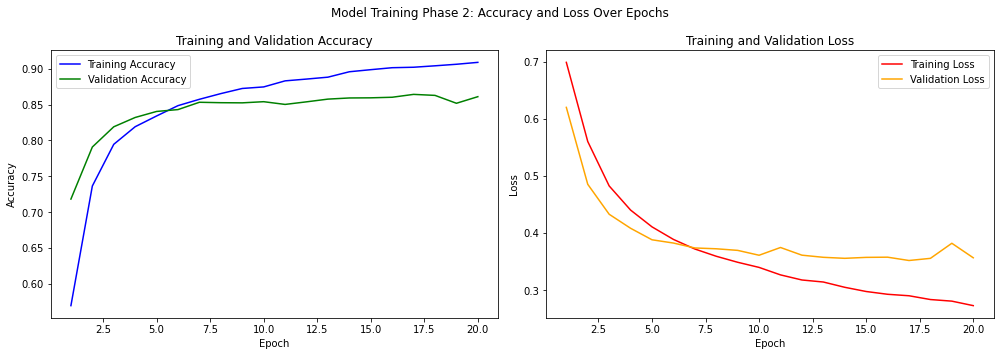

In [18]:


# Converting history into a DataFrame
history_df = pd.DataFrame(history.history)

# Extracting epochs
epochs_range = np.array(range(1, len(history_df) + 1))

# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_df['accuracy'].values, label='Training Accuracy', color='blue')
plt.plot(epochs_range, history_df['val_accuracy'].values, label='Validation Accuracy', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_df['loss'].values, label='Training Loss', color='red')
plt.plot(epochs_range, history_df['val_loss'].values, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Model Training Phase 2: Accuracy and Loss Over Epochs")
plt.tight_layout()
plt.show()

## Model Phase 2 evaluation:
The model's modifications have effectively addressed previous overfitting issues. The output indicates a more stable validation loss and accuracy over the epochs, contrasting with model phase 1 where validation loss increased significantly. The training process now demonstrates a healthier balance between learning from the training data and maintaining performance on unseen data.

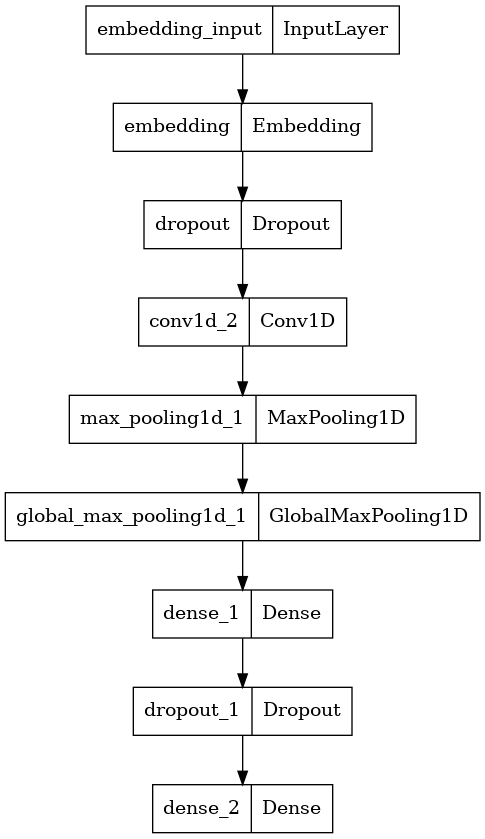

In [19]:
# CNN Architecture for Text Classification:
plot_model(model, to_file='model.png')

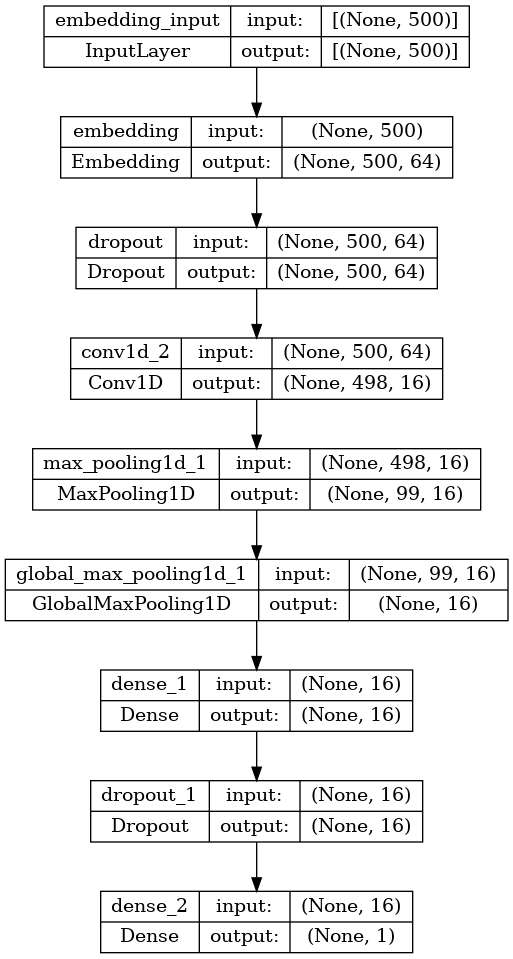

In [20]:
# Detailed CNN Architecture with Layer Outputs for Text Classification:
plot_model(model, show_shapes=True, to_file='model.png')

Due to the recording requirement and the time constraint of 5 to 7 minutes, I'm setting up a timestamp to show the exact time the script was run.

In [21]:
# Getting current date and time
current_time = datetime.now()

# Formatting the date and time in a readable format:
formatted_time = current_time.strftime('%B %d, %Y, %H:%M:%S')

# Print the formatted date and time
print(f"5.API_Data_to_model_CNN.ipynb was last run on: {formatted_time}")

5.API_Data_to_model_CNN.ipynb was last run on: April 05, 2024, 11:44:44


### Bibliography:

Phase 1 of the CNN was adapted from the book `Deep Learning with Python` (Chollet, 2018, pp. 253-259). In Phase 2, the CNN was adjusted to mitigate overfitting.